In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['font.size'] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format


In [2]:
import initial_condition
from process import weight
from visualize import rank as vr


In [3]:
global data_dir, filter_dir, output_dir
data_dir = '../../data/interim/internal/filtered_before_agg/'
filter_dir = '../../data/interim/internal/filter_after_agg/'
output_dir = '../../data/interim/internal/filtered_after_agg/'
ex_dir = '../../data/processed/external/schmoch/'


In [4]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
# top_p_or_num = ('p', 100)
region_corporation = initial_condition.REGION_CORPORATION
# region_corporation = 'right_person_addr'
applicant_weight = initial_condition.APPLICANT_WEIGHT

classification = initial_condition.CLASSIFICATION
classification = 'ipc3'
class_weight = initial_condition.CLASS_WEIGHT

filter_condition = f'{ar}_{year_style}_{extract_population}_reg_num_top_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}'
input_condition = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}'



In [5]:
filter_condition

'app_nendo_all_reg_num_top_p_3_right_person_name'

In [6]:
# 全体
all_df = pd.read_csv(f'{data_dir}japan.csv', 
                     encoding='utf-8', 
                     sep=',', 
                     dtype={'reg_num': str, 
                            region_corporation: str, 
                            f'{ar}_{year_style}': np.int64, 
                            f'{classification}': str})

all_df = all_df[all_df[f'{ar}_{year_style}'].isin(range(year_start, year_end+1))]\
               .drop_duplicates()
all_df = all_df[['reg_num', 'app_nendo', 'right_person_name', 'ipc', 'schmoch35']]
all_df['ipc3'] = all_df['ipc'].str[:3]
all_df['app_nendo_period'] = f'{year_start}-{year_end}'

all_df = all_df.drop(columns=['ipc', 'app_nendo']).drop_duplicates()
# display(all_df.head())


In [7]:
all_df

,reg_num,right_person_name,schmoch35,ipc3,app_nendo_period
726292,1513806,あしゆ羅工房株式会社,29,C03,1981-2010
726293,1448230,あすか製薬株式会社,11,G01,1981-2010
726294,1466808,あすか製薬株式会社,16,A61,1981-2010
726297,1535495,あすか製薬株式会社,14,C07,1981-2010
726298,1557663,あすか製薬株式会社,14,C07,1981-2010
...,...,...,...,...,...
4615543,5451673,Ｚホールデイングス株式会社,6,G06,1981-2010
4615546,5989302,ＺＥＮＴＡ株式会社,8,H01,1981-2010
4615547,5291735,ａｘ株式会社,6,G06,1981-2010
4615548,5838311,ｉーＰＲＯ株式会社,13,A61,1981-2010


In [8]:
# 特許分類による重みづけ
# 全体
if class_weight == 'fraction':
    all_schmoch_df = weight.by_classification(all_df, 'right_person_name', 'schmoch35')
# elif class_weight == 'duplication':
#     all_schmoch_df['class_weight'] = 1

# 共同出願の重みづけ
# 全体
if applicant_weight == 'fraction':
    all_schmoch_df = weight.by_applicant(all_schmoch_df, 'right_person_name')
# elif applicant_weight == 'duplication':
#     all_schmoch_df['applicant_weight'] = 1
display(all_schmoch_df)

# 特許分類による重みづけ
# 全体
if class_weight == 'fraction':
    all_ipc3_df = weight.by_classification(all_df, 'right_person_name', 'ipc3')

# 共同出願の重みづけ
# 全体
if applicant_weight == 'fraction':
    all_ipc3_df = weight.by_applicant(all_ipc3_df, 'right_person_name')
all_ipc3_df



,reg_num,right_person_name,schmoch35,ipc3,app_nendo_period,class_weight,applicant_weight
0,1513806,あしゆ羅工房株式会社,29,C03,1981-2010,1,2
1,1448230,あすか製薬株式会社,11,G01,1981-2010,1,1
2,1466808,あすか製薬株式会社,16,A61,1981-2010,1,1
3,1535495,あすか製薬株式会社,14,C07,1981-2010,1,1
4,1557663,あすか製薬株式会社,14,C07,1981-2010,1,1
...,...,...,...,...,...,...,...
3584819,5451673,Ｚホールデイングス株式会社,6,G06,1981-2010,1,2
3584820,5989302,ＺＥＮＴＡ株式会社,8,H01,1981-2010,1,1
3584821,5291735,ａｘ株式会社,6,G06,1981-2010,1,1
3584822,5838311,ｉーＰＲＯ株式会社,13,A61,1981-2010,1,2


,reg_num,right_person_name,schmoch35,ipc3,app_nendo_period,class_weight,applicant_weight
0,1513806,あしゆ羅工房株式会社,29,C03,1981-2010,1,2
1,1448230,あすか製薬株式会社,11,G01,1981-2010,1,1
2,1466808,あすか製薬株式会社,16,A61,1981-2010,1,1
3,1535495,あすか製薬株式会社,14,C07,1981-2010,1,1
4,1557663,あすか製薬株式会社,14,C07,1981-2010,1,1
...,...,...,...,...,...,...,...
3584819,5451673,Ｚホールデイングス株式会社,6,G06,1981-2010,1,2
3584820,5989302,ＺＥＮＴＡ株式会社,8,H01,1981-2010,1,1
3584821,5291735,ａｘ株式会社,6,G06,1981-2010,1,1
3584822,5838311,ｉーＰＲＯ株式会社,13,A61,1981-2010,1,2


In [9]:
# フィルタリング
reg_num_filter_df = pd.read_csv(f'{filter_dir}{filter_condition}.csv',
                                encoding='utf-8',
                                sep=',', 
                                usecols=[f'{ar}_{year_style}_period', region_corporation],
                                dtype=str)
reg_num_filter_df


,app_nendo_period,right_person_name
0,1981-2010,パナソニツクホールデイングス株式会社
1,1981-2010,キヤノン株式会社
2,1981-2010,株式会社東芝
3,1981-2010,日本電気株式会社
4,1981-2010,三菱電機株式会社
...,...,...
1933,1981-2010,モリタ宮田工業株式会社
1934,1981-2010,スピードフアム株式会社
1935,1981-2010,株式会社ＩＨＩ検査計測
1936,1981-2010,株式会社ＪＣＵ


In [10]:
all_schmoch_df

,reg_num,right_person_name,schmoch35,ipc3,app_nendo_period,class_weight,applicant_weight
0,1513806,あしゆ羅工房株式会社,29,C03,1981-2010,1,2
1,1448230,あすか製薬株式会社,11,G01,1981-2010,1,1
2,1466808,あすか製薬株式会社,16,A61,1981-2010,1,1
3,1535495,あすか製薬株式会社,14,C07,1981-2010,1,1
4,1557663,あすか製薬株式会社,14,C07,1981-2010,1,1
...,...,...,...,...,...,...,...
3584819,5451673,Ｚホールデイングス株式会社,6,G06,1981-2010,1,2
3584820,5989302,ＺＥＮＴＡ株式会社,8,H01,1981-2010,1,1
3584821,5291735,ａｘ株式会社,6,G06,1981-2010,1,1
3584822,5838311,ｉーＰＲＯ株式会社,13,A61,1981-2010,1,2


In [11]:
all_df = pd.merge(all_df, reg_num_filter_df, on=['app_nendo_period', 'right_person_name'], how='inner')
all_df

,reg_num,right_person_name,schmoch35,ipc3,app_nendo_period
0,1448230,あすか製薬株式会社,11,G01,1981-2010
1,1466808,あすか製薬株式会社,16,A61,1981-2010
2,1535495,あすか製薬株式会社,14,C07,1981-2010
3,1557663,あすか製薬株式会社,14,C07,1981-2010
4,1557664,あすか製薬株式会社,14,C07,1981-2010
...,...,...,...,...,...
3180403,5787344,株式会社レゾナツク,2,G11,1981-2010
3180404,5610582,株式会社レゾナツク,20,C22,1981-2010
3180405,5613604,株式会社レゾナツク,21,C30,1981-2010
3180406,5737676,株式会社レゾナツク,2,G11,1981-2010


In [12]:
df = pd.merge(all_schmoch_df, reg_num_filter_df, on=[f'{ar}_{year_style}_period', 'right_person_name'], how='inner')
all_schmoch_reg_num_df = df.copy()
all_schmoch_reg_num_df['reg_num'] = 1 / all_schmoch_reg_num_df['class_weight'] / all_schmoch_reg_num_df['applicant_weight']
all_schmoch_reg_num_df = all_schmoch_reg_num_df.groupby([f'{ar}_{year_style}_period', 'right_person_name', 'schmoch35'], as_index=False)[['reg_num']]\
                               .sum()\
                               .sort_values(['reg_num'], ascending=[False])
all_schmoch_reg_num_df

df = pd.merge(all_ipc3_df, reg_num_filter_df, on=[f'{ar}_{year_style}_period', 'right_person_name'], how='inner')
all_ipc3_reg_num_df = df.copy()
all_ipc3_reg_num_df['reg_num'] = 1 / all_ipc3_reg_num_df['class_weight'] / all_ipc3_reg_num_df['applicant_weight']
all_ipc3_reg_num_df = all_ipc3_reg_num_df.groupby([f'{ar}_{year_style}_period', 'right_person_name', 'ipc3'], as_index=False)[['reg_num']]\
                               .sum()\
                               .sort_values(['reg_num'], ascending=[False])
all_ipc3_reg_num_df


,app_nendo_period,right_person_name,ipc3,reg_num
9115,1981-2010,パナソニツクホールデイングス株式会社,H01,20725.824
2849,1981-2010,キヤノン株式会社,G03,17806.500
29257,1981-2010,日本電気株式会社,H04,16425.177
23983,1981-2010,富士通株式会社,G06,15535.426
41970,1981-2010,株式会社リコー,G03,15516.083
...,...,...,...,...
18103,1981-2010,北陸電力株式会社,B05,0.071
15667,1981-2010,九州電力株式会社,B05,0.071
9,1981-2010,いすゞ自動車株式会社,A01,0.071
37257,1981-2010,株式会社クラレ,B09,0.056


In [13]:
all_ipc3_reg_num_df

,app_nendo_period,right_person_name,ipc3,reg_num
9115,1981-2010,パナソニツクホールデイングス株式会社,H01,20725.824
2849,1981-2010,キヤノン株式会社,G03,17806.500
29257,1981-2010,日本電気株式会社,H04,16425.177
23983,1981-2010,富士通株式会社,G06,15535.426
41970,1981-2010,株式会社リコー,G03,15516.083
...,...,...,...,...
18103,1981-2010,北陸電力株式会社,B05,0.071
15667,1981-2010,九州電力株式会社,B05,0.071
9,1981-2010,いすゞ自動車株式会社,A01,0.071
37257,1981-2010,株式会社クラレ,B09,0.056


In [14]:
def kh_ki(c_df, classification, n=19):
    kh1_ki1_df = pd.merge(c_df.copy(), 
                        c_df[c_df['mcp']==1].groupby(['right_person_name'])[['ubiquity']].sum().reset_index(drop=False).copy().rename(columns={'ubiquity':'kh_1'}), 
                        on=['right_person_name'], how='left')
    kh1_ki1_df = pd.merge(kh1_ki1_df.copy(), 
                        c_df[c_df['mcp']==1].groupby([classification])[['diversity']].sum().reset_index(drop=False).copy().rename(columns={'diversity':'ki_1'}), 
                        on=[classification], how='left')
    kh1_ki1_df['kh_1'] = kh1_ki1_df['kh_1'] / kh1_ki1_df['diversity']
    kh1_ki1_df['ki_1'] = kh1_ki1_df['ki_1'] / kh1_ki1_df['ubiquity']
    kh_ki_df = kh1_ki1_df.copy()
    for i in range(n):
        kh_ki_df = pd.merge(kh_ki_df, 
                            kh_ki_df[kh_ki_df['mcp']==1].groupby(['right_person_name'])[[f'ki_{i+1}']].sum().reset_index(drop=False).copy()\
                                        .rename(columns={f'ki_{i+1}':f'kh_{i+2}'}), 
                            on=['right_person_name'], how='left')
        kh_ki_df = pd.merge(kh_ki_df, 
                            kh_ki_df[kh_ki_df['mcp']==1].groupby([classification])[[f'kh_{i+1}']].sum().reset_index(drop=False).copy()\
                                        .rename(columns={f'kh_{i+1}':f'ki_{i+2}'}), 
                            on=[classification], how='left')
        kh_ki_df[f'kh_{i+2}'] = kh_ki_df[f'kh_{i+2}'] / kh_ki_df['diversity']
        kh_ki_df[f'ki_{i+2}'] = kh_ki_df[f'ki_{i+2}'] / kh_ki_df['ubiquity']
    return kh_ki_df


In [15]:
trade_cols = {'time':f'{ar}_{year_style}_period', 'loc':'right_person_name', 'prod':'schmoch35', 'val':'reg_num'}
rename_col_dict = {'eci':'kci', 'pci':'tci'}
col_order_list = [f'{ar}_{year_style}_period', 'right_person_name', 'schmoch35', 'reg_num', 'rca', 'mcp', 'diversity', 'ubiquity', 'kci', 'tci']

c_df = ecomplexity(all_schmoch_reg_num_df,
                   cols_input = trade_cols, 
                   rca_mcp_threshold = 1)
# c_out_df = c_df.copy()
c_df = c_df[c_df['reg_num'] > 0]\
           .rename(columns=rename_col_dict)\
           [col_order_list]
c_df = pd.concat([kh_ki(c_df[c_df[f'{ar}_{year_style}_period'] == period], 'schmoch35') for period in c_df[f'{ar}_{year_style}_period'].unique()], 
                 axis='index', 
                 ignore_index=True)

c_df = c_df[[f'{ar}_{year_style}_period', 'schmoch35', 'tci']].drop_duplicates()
c_df['tci'] = (c_df['tci'] - c_df['tci'].min()) / (c_df['tci'].max() - c_df['tci'].min()) * 100
# c_df = c_df[[f'{ar}_{year_style}_period', classification, 'tci']]
# pre_df = c_df[[f'{ar}_{year_style}_period', classification, 'tci']].copy()

1981-2010


In [16]:
trade_cols = {'time':f'{ar}_{year_style}_period', 'loc':'right_person_name', 'prod':'ipc3', 'val':'reg_num'}
rename_col_dict = {'eci':'kci', 'pci':'tci'}
col_order_list = [f'{ar}_{year_style}_period', 'right_person_name', 'ipc3', 'reg_num', 'rca', 'mcp', 'diversity', 'ubiquity', 'kci', 'tci']

ipc3_c_df = ecomplexity(all_ipc3_reg_num_df,
                   cols_input = trade_cols, 
                   rca_mcp_threshold = 1)
# c_out_df = c_df.copy()
ipc3_c_df = ipc3_c_df[ipc3_c_df['reg_num'] > 0]\
           .rename(columns=rename_col_dict)\
           [col_order_list]
ipc3_c_df = pd.concat([kh_ki(ipc3_c_df[ipc3_c_df[f'{ar}_{year_style}_period'] == period], 'ipc3') for period in ipc3_c_df[f'{ar}_{year_style}_period'].unique()], 
                 axis='index', 
                 ignore_index=True)
ipc3_c_df = ipc3_c_df[[f'{ar}_{year_style}_period', 'ipc3', 'tci']].drop_duplicates()
ipc3_c_df['tci'] = (ipc3_c_df['tci'] - ipc3_c_df['tci'].min()) / (ipc3_c_df['tci'].max() - ipc3_c_df['tci'].min()) * 100
# c_df['schmoch35'] = c_df['schmoch35'].astype(int)
# schmoch_df = pd.read_csv(f'{ex_dir}35.csv', 
#                          encoding='utf-8', 
#                          sep=',', 
#                          usecols=['Field_number', 'Field_en']
#                          ).drop_duplicates()

# c_df = pd.merge(c_df, 
#                 schmoch_df, 
#                 left_on=['schmoch35'], 
#                 right_on=['Field_number'], 
                # how='left').drop(columns=['Field_number', 'schmoch35']).rename(columns={'Field_en': 'schmoch35'})
# c_df = c_df[[f'{ar}_{year_style}_period', classification, 'tci']]
# pre_df = c_df[[f'{ar}_{year_style}_period', classification, 'tci']].copy()

1981-2010


In [17]:
all_df['schmoch35'] = all_df['schmoch35'].astype(str)
c_df['schmoch35'] = c_df['schmoch35'].astype(str)
ipc3_c_df['ipc3'] = ipc3_c_df['ipc3'].astype(str)

In [18]:
ipc3_schmoch_df = pd.merge(all_df[['schmoch35', 'ipc3']].drop_duplicates(), c_df, on=['schmoch35'], how='outer')[['schmoch35', 'ipc3', 'tci']].drop_duplicates()\
                          .rename(columns={'tci':'schmoch35_tci'})
ipc3_schmoch_df = pd.merge(ipc3_schmoch_df, ipc3_c_df, on=['ipc3'], how='outer')[['schmoch35', 'ipc3', 'schmoch35_tci', 'tci']]\
                            .rename(columns={'tci':'ipc3_tci'}).drop_duplicates()
schmoch_df = pd.read_csv(f'{ex_dir}35.csv', 
                         encoding='utf-8', 
                         sep=',', 
                         usecols=['Field_number', 'Field_en'], 
                         dtype=str
                         ).drop_duplicates()

ipc3_schmoch_df = pd.merge(ipc3_schmoch_df, 
                schmoch_df, 
                left_on=['schmoch35'], 
                right_on=['Field_number'], 
                how='left').drop(columns=['Field_number', 'schmoch35']).rename(columns={'Field_en': 'schmoch35'})
eu_df = pd.read_csv('../../data/processed/external/abroad/eu.csv', 
                    encoding='utf-8', 
                    sep=',')
eu_df
ipc3_schmoch_df = pd.merge(ipc3_schmoch_df, eu_df[['schmoch35', 'schmoch5']], on='schmoch35', how='left')
ipc3_schmoch_df['schmoch5'] = ipc3_schmoch_df['schmoch5'].replace('Mechanical engineering', 'Mechanical engineering, machinery')
ipc3_schmoch_df['schmoch5'] = ipc3_schmoch_df['schmoch5'].replace('Chemistry', 'Chemistry, pharmaceuticals')
ipc3_schmoch_df['schmoch5'] = np.where(ipc3_schmoch_df['schmoch35']=='Machine tools', 
                                 'Mechanical engineering, machinery', 
                                 np.where(ipc3_schmoch_df['schmoch35']=='Analysis of biological materials', 
                                          'Instruments', 
                                          ipc3_schmoch_df['schmoch5']))
ipc3_schmoch_df = ipc3_schmoch_df.sort_values('schmoch35_tci', ascending=False)
ipc3_schmoch_df


,ipc3,schmoch35_tci,ipc3_tci,schmoch35,schmoch5
3,A61,100.000,83.738,Pharmaceuticals,"Chemistry, pharmaceuticals"
4,A61,98.984,83.738,Organic fine chemistry,"Chemistry, pharmaceuticals"
6,C07,98.984,90.818,Organic fine chemistry,"Chemistry, pharmaceuticals"
8,C40,98.984,60.106,Organic fine chemistry,"Chemistry, pharmaceuticals"
47,A21,96.068,91.357,Food chemistry,"Chemistry, pharmaceuticals"
...,...,...,...,...,...
150,G10,9.579,9.176,Computer technology,Electrical engineering
141,G08,7.416,37.304,Telecommunications,Electrical engineering
126,H01,7.416,48.289,Telecommunications,Electrical engineering
162,H04,7.416,0.000,Telecommunications,Electrical engineering


In [23]:
ipc3_schmoch_df['ipc3'].nunique()
ipc3_schmoch_df['schmoch35'].nunique()

35

In [36]:
translation_dict = {
    "Pharmaceuticals": "医薬品",
    "Organic fine chemistry": "有機ファインケミカル",
    "Food chemistry": "食品化学",
    "Biotechnology": "バイオテクノロジー",
    "Macromolecular chemistry, polymers": "高分子化学、ポリマー",
    "Basic materials chemistry": "基礎材料化学",
    "Analysis of biological materials": "生物材料の分析",
    "Other special machines": "その他の特殊機械",
    "Chemical engineering": "化学工学",
    "Materials, metallurgy": "材料、冶金",
    "Surface technology, coating": "表面技術、コーティング",
    "Environmental technology": "環境技術",
    "Medical technology": "医療技術",
    "Civil engineering": "土木工学",
    "Thermal processes and apparatus": "熱処理および装置",
    "Machine tools": "工作機械",
    "Mechanical elements": "機械要素",
    "Handling": "取り扱い",
    "Engines, pumps, turbines": "エンジン、ポンプ、タービン",
    "Textile and paper machines": "繊維および紙の機械",
    "Transport": "交通",
    "Other consumer goods": "その他の消費財",
    "Furniture, games": "家具、ゲーム",
    "Measurement": "測定",
    "Optics": "光学",
    "Micro-structural and nano-technology": "マイクロ構造とナノテクノロジー",
    "Electrical machinery, apparatus, energy": "電気機器、装置、エネルギー",
    "Semiconductors": "半導体",
    "IT methods for management": "管理のためのIT手法",
    "Control": "制御",
    "Audio-visual technology": "映像・音響技術",
    "Basic communication processes": "基本通信プロセス",
    "Computer technology": "コンピュータ技術",
    "Telecommunications": "通信",
    "Digital communication": "デジタル通信"
}


C:\Users\rin\AppData\Local\Temp\ipykernel_865440\2855278413.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ipc3_schmoch_df['schmoch35'].drop_duplicates(), rotation=90)


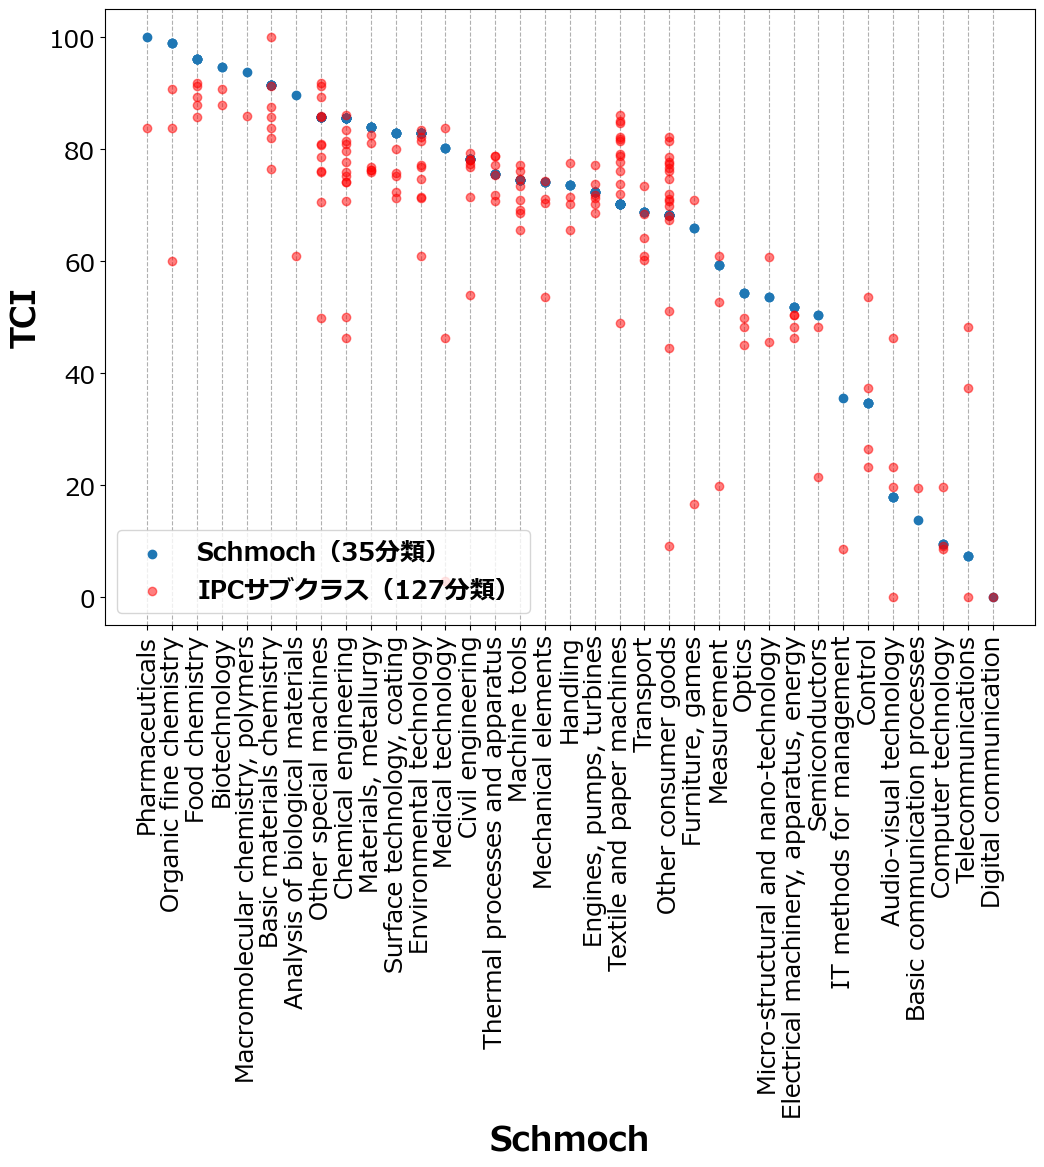

In [42]:
tech_color = {
        'Chemistry, pharmaceuticals': 'red',
        'Electrical engineering': 'blue',
        'Instruments': 'green', 
        'Mechanical engineering, machinery': 'orange',
        'Other fields': 'gray'
    }
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots(figsize=(12, 8))

# for tech_color_key in tech_color.keys():
#     ax.scatter(ipc3_schmoch_df[ipc3_schmoch_df['schmoch5']==tech_color_key]['schmoch35'], ipc3_schmoch_df[ipc3_schmoch_df['schmoch5']==tech_color_key]['schmoch35_tci'], 
#             color=tech_color[tech_color_key], label=tech_color_key, 
#             s=60)
ax.grid(True, linestyle='--', which='major', axis='x')

# ax.scatter(ipc3_schmoch_df['schmoch35'], ipc3_schmoch_df['schmoch35_tci'], s=40,
#            label='35 tech classification (N=35)')
# ax.scatter(ipc3_schmoch_df['schmoch35'], ipc3_schmoch_df['ipc3_tci'], color='tab:orange', alpha=0.6,
#            label='detailed tech classification (N=124)')
ax.scatter(ipc3_schmoch_df['schmoch35'], ipc3_schmoch_df['schmoch35_tci'], color='tab:blue', label='Schmoch（35分類）')
ax.scatter(ipc3_schmoch_df['schmoch35'], ipc3_schmoch_df['ipc3_tci'], color='red', alpha=0.5, 
           label='IPCサブクラス（127分類）')
# ax2 = ax.secondary_yaxis('right')
# ax2.set_ylabel('TCI', fontsize=24, fontweight='bold')
# ax.set_xticklabels([translation_dict[sch] for sch in ipc3_schmoch_df['schmoch35'].drop_duplicates()], rotation=90)
ax.set_xticklabels(ipc3_schmoch_df['schmoch35'].drop_duplicates(), rotation=90)


# ax.set_title(r"$\bf{" + 'Corporations'+ "}$", fontsize=24)
ax.set_xlabel('Schmoch', fontsize=24, fontweight='bold')
ax.set_ylabel('TCI', fontsize=24, fontweight='bold')

# ax.set_xscale('log')
# ax.legend(loc='center left', fontsize=20, bbox_to_anchor=(1.5, 0.5), borderaxespad=0, prop={'weight': 'bold'})
ax.legend(loc='lower left', fontsize=20, prop={'weight': 'bold'})

plt.show()


1981-2010 0.811


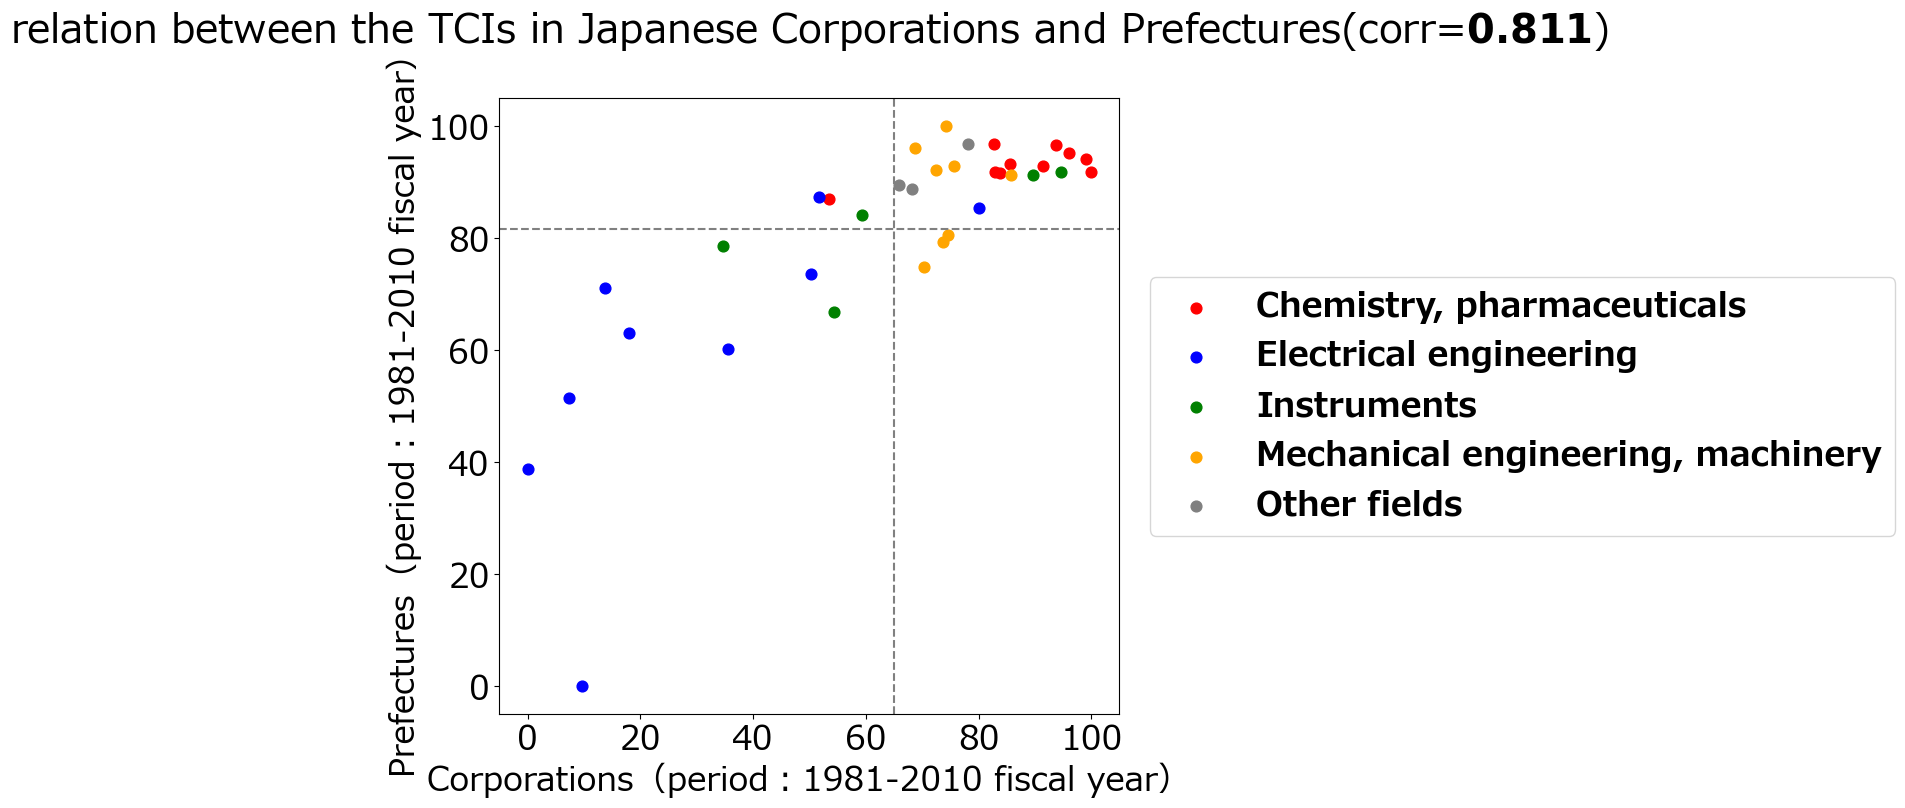

1981-2010 0.761


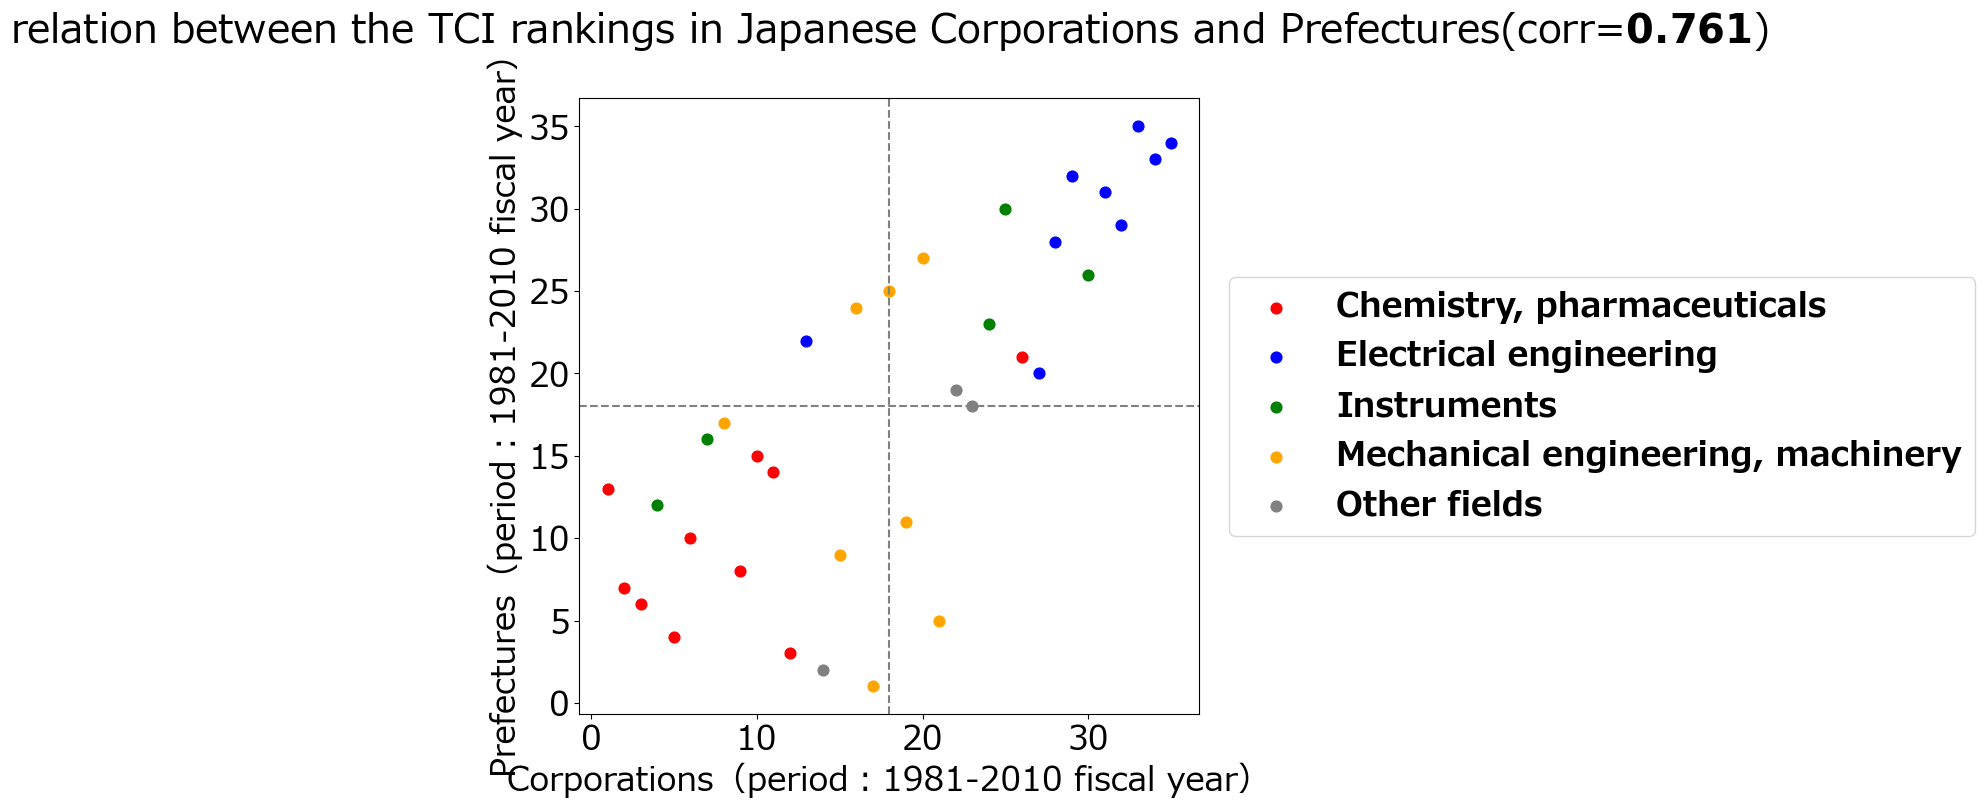

In [143]:
df_dict = {}
tech_color = {
        'Chemistry, pharmaceuticals': 'red',
        'Electrical engineering': 'blue',
        'Instruments': 'green', 
        'Mechanical engineering, machinery': 'orange',
        'Other fields': 'gray'
    }
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["co_tci", "pre_tci", "relation between the TCIs in Japanese Corporations and Prefectures", "Corporations（period：1981-2010 fiscal year）", "Prefectures（period：1981-2010 fiscal year）", "center", ],
    2: ["co_tci_rank", "pre_tci_rank", "relation between the TCI rankings in Japanese Corporations and Prefectures", "Corporations（period：1981-2010 fiscal year）", "Prefectures（period：1981-2010 fiscal year）", "center", ],
    # 2: ["TCI_rank_jp", "TCI_rank_eu", "relation between the TCIs in Japanese corporation and EU regions", "Japanese Corporations ranking（period：1981-2010 fiscal year）", "EU Regions ranking（period：1985-2009 year）", "center", ],
    # 2: ["reg_num_jp", "reg_num_eu", "corr between the patent amounts in Japan and EU", "Japan（period：1981-2010 fiscal year）", "EU（period：1985-2009 year）", "center", ],
    # 3: ["reg_num_jp", "TCI_jp", "relation between the patent counts and the TCIs in Japan", "Patent Counts", "TCIs", "center left", ],
    # 4: ["TCI_jp", "reg_num_jp", "relation between the patent counts and the TCIs in Japan", "TCIs", "Patent Counts", "center left", ],
    # 5: ["reg_num_eu", "TCI_eu", "corr between the patent amounts in EU and TCI in EU", "EU（period：1985-2009 year）", "EU（period：1985-2009 year）", "center", ],
    # 2: ["TCI_eu", "TCI_jp", "corr between the TCIs in Japan and EU", "EU（period：1985-2009 year）", "Japan（period：1981-2010 fiscal year）", "center", ],
}
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Meiryo'
for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(pre_co_df[combi[0]].corr(pre_co_df[combi[1]]), 3)
    print(period, corr_num)
    # ax.scatter(pre_co_df[combi[0]], pre_co_df[combi[1]],
    #            s=20, alpha=0.8, color="black", )
    # if i == 4:
    ax.axvline(x=pre_co_df[combi[0]].mean(), color="gray", linestyle="--", )
    ax.axhline(y=pre_co_df[combi[1]].mean(), color="gray", linestyle="--", )
    ax.set_title(combi[2]+'(corr=' + r"$\bf{" + str(corr_num)+ "}$" +')\n')
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = pre_co_df[combi[0]].min()
    x_2smallest = (pre_co_df[combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (pre_co_df[combi[1]].nsmallest(2).iloc[1])
    head_df = pre_co_df.head(5)
    between_df = pre_co_df.iloc[5:len(pre_co_df)-5, :]
    tail_df = pre_co_df.tail(5)
    if i != 5:
        # display(pre_co_df)
        # for i, row in head_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="red")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
        # for i, row in between_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=15, color="black")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
        # for i, row in tail_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="blue", )
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
        # for i, row in head_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="red")
            
            # if i == 4: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']], label=row['schmoch5'])
            # else: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']])
        # for i, row in between_df.iterrows():
        #     # ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=15, color="black")
        #     if i == 7: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']], label=row['schmoch5'])
        #     else: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']])
            
        # for i, row in tail_df.iterrows():
        #     # ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=18, color="blue")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=40, color="blue", label=f'{i+1} {row["schmoch35"]}')
        for tech_color_key in tech_color.keys():
            ax.scatter(pre_co_df[pre_co_df['schmoch5']==tech_color_key][combi[0]], pre_co_df[pre_co_df['schmoch5']==tech_color_key][combi[1]], 
                       color=tech_color[tech_color_key], label=tech_color_key, 
                       s=60)
        # for i, row in pre_co_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="black")
        # for ind, row in head_df.iterrows():
        #     if ind == 1: ax.text(row[combi[0]]+1, row[combi[1]]-2, f'\n{ind+1} {row["schmoch35"]}', fontsize=20, color=tech_color[row['schmoch5']])
        #     else: ax.text(row[combi[0]]+1, row[combi[1]]-1, f'{ind+1} {row["schmoch35"]}', fontsize=20, color=tech_color[row['schmoch5']])
    # elif i == 2:
    #     for i, row in head_df.iterrows():
    #         ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=18, color="red")
    #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
    #     for i, row in between_df.iterrows():
    #         ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=15, color="black")
    #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
    #     for i, row in tail_df.iterrows():
    #         ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=18, color="blue", )
    #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    # ax.set_xscale('log')
    ax.legend(loc=combi[5], fontsize=20, bbox_to_anchor=(1.65, 0.5), borderaxespad=0, prop={'weight': 'bold'})
    plt.show()
